In [62]:
import cv2
import numpy as np

background = None
accumulated_weight = 0.5

ROI_top = 75
ROI_bottom = 325
ROI_right = 250
ROI_left = 500

In [63]:
background = None
def cal_accum_avg(frame, accumulated_weight=0.5):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [64]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)
    cv2.imshow("diff", diff)

    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    cv2.imshow("thresholded_segment_hand", thresholded)

    # Grab the external contours for the image
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [65]:
cam = cv2.VideoCapture(0)

num_frames = 0
element = 1
num_imgs_taken = 0


while True:
    ret, frame = cam.read()

    # filpping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)
    canny_gray = cv2.Canny(gray_frame, 100,200, apertureSize=3, L2gradient=True)
#     cv2.imshow('grayframe', gray_frame)
    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
#             cv2.imshow("Sign Detection",frame_copy)
         
    #Time to configure the hand specifically into the ROI...
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        cv2.putText(frame_copy, "Adjust hand...Gesture for " + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        # Checking if hand is actually detected by counting number of contours detected...
        if hand is not None:
            
            thresholded, hand_segment = hand
#             cv2.imshow("thresholded", thresholded)

            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            cv2.drawContours(gray_frame, hand_segment, -1, (255, 0, 0),1)
            canny_gray = cv2.Canny(gray_frame, 100, 200,  apertureSize=3, L2gradient=True)
            canny_white = cv2.Canny(roi, 100, 125)
            
        
            
            cv2.putText(frame_copy, str(num_frames)+" images for " + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image_elif", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            cv2.drawContours(gray_frame, hand_segment, -1, (255, 0, 0),1)
            canny_gray = cv2.Canny(gray_frame, 100,200, apertureSize=3,L2gradient=True)
            canny_white = cv2.Canny(roi, 100,125)
            
            
#             cv2.putText(frame_copy, str(num_frames), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
#             #cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
#             cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image_else", thresholded)
#             if num_imgs_taken <= 300:
#                 cv2.imwrite(r"D:\\Desktop\ML\\sign_language\\gesture\\train\\"+str(element)+"\\" + str(num_imgs_taken) + '.jpg', thresholded)
# #                 cv2.imwrite(r"D:\Desktop\ML\sign_language\gesture"+"\\" + str(num_imgs_taken) + '.jpg', thresholded)
#             else:
#                 break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)
    cv2.imshow("gray_frame", gray_frame)
    cv2.imshow("canny_gray", canny_gray)
    cv2.imshow("canny_white", canny_white)
    

    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

In [66]:
# Releasing camera & destroying all the windows...

cv2.destroyAllWindows()
cam.release()

Training CNN

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
# from keras.optimizers import Adam, SGD
from keras.optimizers import gradient_descent_v2
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import itertools
import random
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt

In [2]:

train_path = r'D:\Desktop\ML\sign_language\gesture\contours\train'
test_path = r'D:\Desktop\ML\sign_language\gesture\contours\test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), classes =['1','2','3','4','5','6','7','8','9','10'],  class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), classes = ['1','2','3','4','5','6','7','8','9','10'], class_mode='categorical', batch_size=10, shuffle=True)

imgs, labels = next(train_batches)


Found 3010 images belonging to 10 classes.
Found 410 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

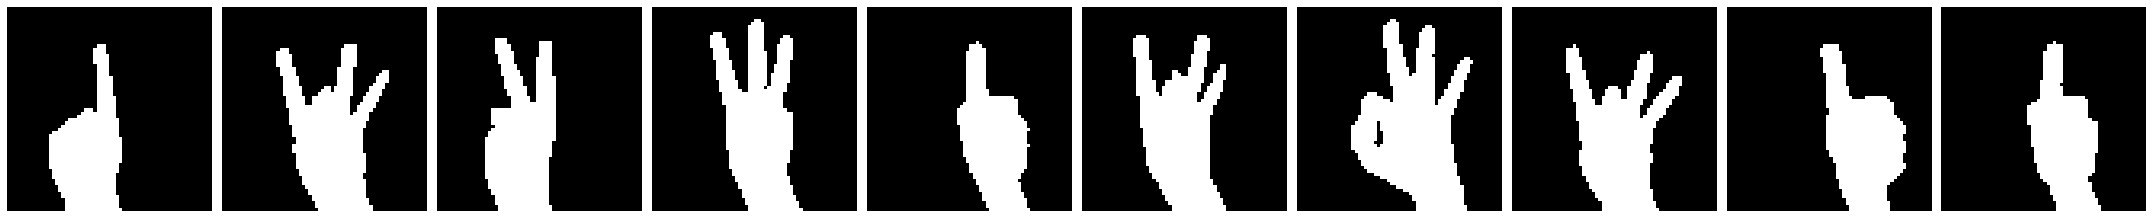

(10, 64, 64, 3)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [3]:

#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)



In [4]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(64,activation ="relu"),
    Dense(128,activation ="relu"),
    Dense(128,activation ="relu"),
    Dense(10,activation ="softmax")
])

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
# model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
# model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
# model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# model.add(Flatten())

# model.add(Dense(64,activation ="relu"))
# model.add(Dense(128,activation ="relu"))
# #model.add(Dropout(0.2))
# model.add(Dense(128,activation ="relu"))
# #model.add(Dropout(0.3))
# model.add(Dense(10,activation ="softmax"))


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [6]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

# model.compile(optimizer=gradient_descent_v2.SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


Epoch 1/10
301/301 [==============================] - 31s 98ms/step - loss: 0.6721 - accuracy: 0.8924 - val_loss: 1.8603 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 2/10
301/301 [==============================] - 19s 64ms/step - loss: 5.1825e-04 - accuracy: 1.0000 - val_loss: 1.5280 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 3/10
301/301 [==============================] - 17s 55ms/step - loss: 8.8749e-05 - accuracy: 1.0000 - val_loss: 1.4853 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 4/10
301/301 [==============================] - 17s 57ms/step - loss: 1.8161e-05 - accuracy: 1.0000 - val_loss: 1.5163 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 5/10
301/301 [==============================] - 16s 55ms/step - loss: 1.3325e-05 - accuracy: 1.0000 - val_loss: 1.5218 - val_accuracy: 0.8171 - lr: 2.0000e-04
loss of 0.038020022213459015; accuracy of 100.0%


In [7]:

#model.save('best_model_dataflair.h5')
model.save('best_model_dataflair3.h5')

print(history2.history)

imgs, labels = next(test_batches)

model = keras.models.load_model(r"best_model_dataflair3.h5")

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

# model.summary()

scores #[loss, accuracy] on test data...
model.metrics_names

{'loss': [0.6720829010009766, 0.0005182483000680804, 8.874863124219701e-05, 1.81614414032083e-05, 1.3324547580850776e-05], 'accuracy': [0.8923587799072266, 1.0, 1.0, 1.0, 1.0], 'val_loss': [1.8603191375732422, 1.528037190437317, 1.4853137731552124, 1.5163371562957764, 1.5217989683151245], 'val_accuracy': [0.7317073345184326, 0.7756097316741943, 0.8170731663703918, 0.8170731663703918, 0.8170731663703918], 'lr': [0.001, 0.001, 0.001, 0.001, 0.00020000001]}
loss of 0.07951419055461884; accuracy of 100.0%


['loss', 'accuracy']

predictions on a small set of test data--

[[3.32638336e-07 3.27940941e-09 1.43053194e-10 9.99961972e-01
  3.64414518e-05 1.08064546e-06 4.54704931e-08 7.04018549e-13
  1.23187164e-07 2.30199262e-14]
 [6.44561986e-13 4.24568353e-10 1.65926431e-12 2.18683871e-09
  3.35525124e-06 5.26517985e-09 2.39526816e-08 9.99996543e-01
  4.66546695e-08 3.32603989e-08]
 [7.42280406e-08 9.99962330e-01 5.74957994e-06 1.39575929e-09
  7.78804528e-15 3.15085381e-05 3.87593541e-10 1.37405720e-09
  3.74402987e-07 2.98811635e-11]
 [3.35418875e-08 1.36852257e-11 7.93022592e-12 9.99997497e-01
  2.06992740e-06 1.73413994e-08 9.29181798e-09 2.35585141e-12
  4.13324273e-07 1.93383530e-15]
 [9.10208564e-06 2.87864041e-05 9.58254755e-01 6.08843002e-05
  1.18200704e-02 2.98152547e-02 1.16862884e-08 5.03899367e-10
  1.12098814e-05 2.05788044e-08]
 [1.37082335e-13 8.00901984e-11 2.43371865e-13 1.37909434e-10
  5.92585572e-08 3.16523724e-10 2.34926900e-09 9.99999881e-01
  1.47307437e-08 1.15582575e-08]
 [2.39699549e-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

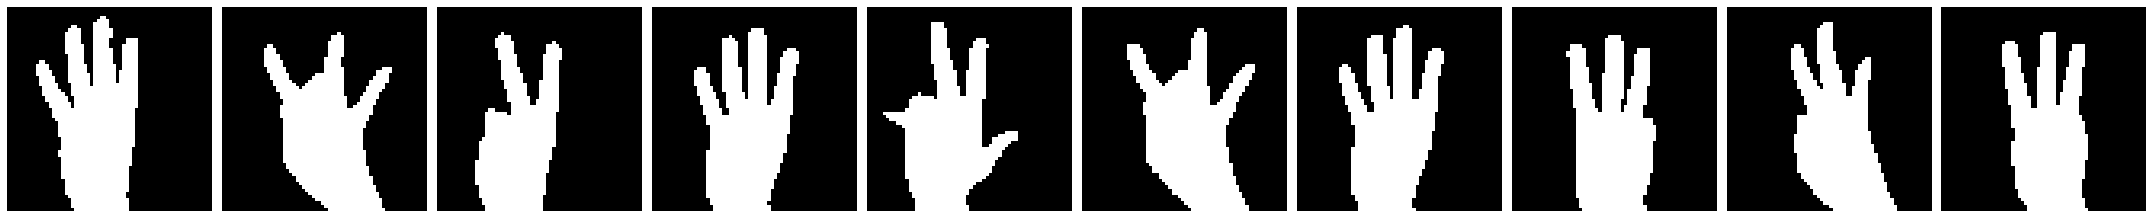

Actual labels
4
8
2
4
3
8
4
6
7
6
(10, 64, 64, 3)


{'loss': [0.6720829010009766,
  0.0005182483000680804,
  8.874863124219701e-05,
  1.81614414032083e-05,
  1.3324547580850776e-05],
 'accuracy': [0.8923587799072266, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [1.8603191375732422,
  1.528037190437317,
  1.4853137731552124,
  1.5163371562957764,
  1.5217989683151245],
 'val_accuracy': [0.7317073345184326,
  0.7756097316741943,
  0.8170731663703918,
  0.8170731663703918,
  0.8170731663703918],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.00020000001]}

In [8]:
word_dict = {'1':'One','2':'Two','3':'Three','4':'Four','5':'Five','6':'Six','7':'Seven','8':'Eight','9':'Nine', '10':'Ten'}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
print(predictions)
for ind, i in enumerate(predictions):
    print(np.argmax(i)+1)
#     print(word_dict[str(np.argmax(i))], end='   ')

plotImages(imgs)
print('Actual labels')
for i in labels:
#     print(word_dict[np.argmax(i)], end='   ')
    print(np.argmax(i)+1)

print(imgs.shape)

history2.history